In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
! kaggle datasets download ashwinishet/amazon-laptop-review

Dataset URL: https://www.kaggle.com/datasets/ashwinishet/amazon-laptop-review
License(s): unknown
  0% 0.00/36.5k [00:00<?, ?B/s]
100% 36.5k/36.5k [00:00<00:00, 42.4MB/s]


In [12]:
import zipfile
zip_ref =  zipfile.ZipFile('/content/amazon-laptop-review.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

### Introduction:
In today's fast-paced world, choosing the right laptop can be a daunting task with endless features, specifications, and user feedback to consider. To simplify this decision-making process, we analyzed a large set of Amazon customer reviews using Latent Dirichlet Allocation (LDA) - a machine learning technique that uncovers hidden themes within vast amounts of textual data. In this review, we’ll dive into these findings to present a clearer, data-driven perspective on the strengths and weaknesses of popular laptop models.

### import libraries

In [18]:
# Basic Libraries
import pandas as pd
import numpy as np

# Preprocessing tool
import spacy

# Genism
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

### Analysis:

In [19]:
df = pd.read_csv(r'/content/amazon_review.csv')
df.head().style.background_gradient(cmap='Blues')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,comments,rating,title
0,Very slow and not good 8gb ram according speed very slow and hang bad laptop plz don't money west,4.000000,Very solow speed and hang laptop bad
1,Really hate the product. Its wastage of money. Its taking too long to start and its making a wierd noice in the background its too heavy and large and is not handy at ol.worst part is that they are not even ready to refund nor replace. Really pissed off,1.000000,Its a regret!!
2,The Product Worth it,5.000000,Good Product
3,Your browser does not support HTML5 video. Please don't buy this laptop. The screen keeps freezing. I bought this laptop for my daughters online classes but every 15-20mins whether using zoom or Microsoft teams it keeps freezing. Processor is too slow. Was coming back to HP brand after a gap of 10 years but this has reminded me that why I stayed away all these years. Please do not waste your hard earned money on this.,1.000000,Please don't buy
4,This is a review after more than 6 months of usage.I had an azuz laptop. But since I had many problems while operating it I ordered this one. At first it was good But now it keeps switching off at times. At first had 9 hR battery now only 3-4 hrs. Not happy with the purchase.,2.000000,Not good


In [20]:
# Finding any null value
df.isnull().sum()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0
comments,2
rating,0
title,0


In [21]:
# Drop null value
df.dropna(inplace = True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
# Dataset Info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 509 entries, 0 to 510
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   comments  509 non-null    object 
 1   rating    509 non-null    float64
 2   title     509 non-null    object 
dtypes: float64(1), object(2)
memory usage: 15.9+ KB


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


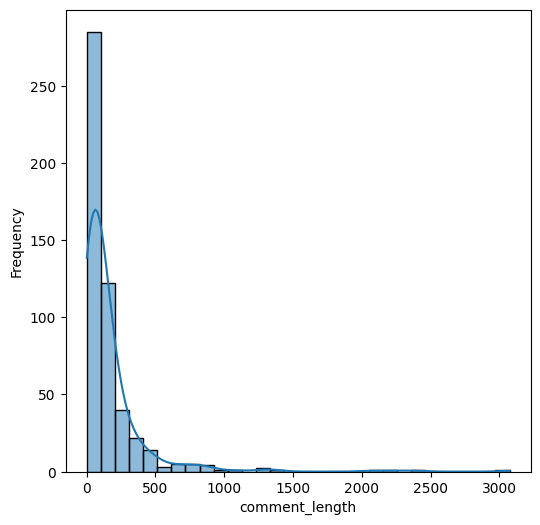

In [31]:
# Comment Distribution
df['comment_length'] = df['comments'].apply(len)

plt.figure(figsize = (6,6))
sns.histplot(x = df['comment_length'], kde = True, bins = 30)
plt.xlabel('comment_length')
plt.ylabel('Frequency')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


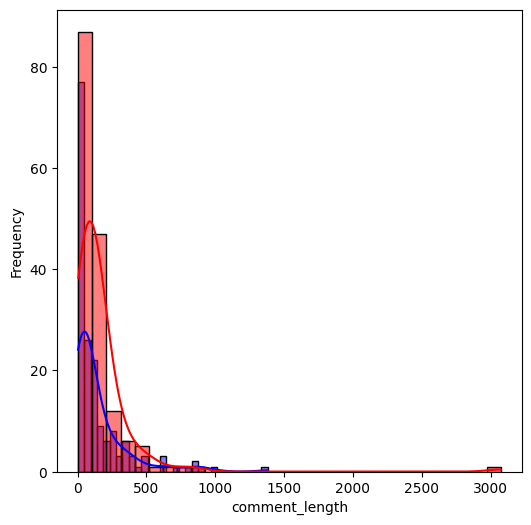

In [35]:
# Distribution for the comments with Rating
plt.figure(figsize = (6,6))
sns.histplot(x = df[df['rating'] == 5.0]['comment_length'], kde = True, bins = 30, color = 'blue')
sns.histplot(x = df[df['rating'] == 1.0]['comment_length'], kde = True, bins = 30, color = 'red')
plt.xlabel('comment_length')
plt.ylabel('Frequency')
plt.show()

Shows that both figures are rightly skewed. However, it is quite unique that when ratings are high the comment-legnth increases and vice versa.

### Preprocessing:

In [38]:
nlp = spacy.load('en_core_web_sm')

def remove_urls(text):
  doc = nlp(text)
  filtered = [token.text for token in doc if not token.text.startswith(('http', 'www'))]
  return ' '.join(filtered)

def remove_emoji(text):
  doc = nlp(text)
  filtered = [token.text for token in doc if token.is_ascii]
  return ' '.join(filtered)

def remove_punctuations_characters(text):
  doc = nlp(text)
  filtered = [token.text for token in doc if token.is_alpha]
  return ' '.join(filtered)

def remove_extra_spaces(text):
  return ' '.join(text.split())

def clean_text(text):
  if isinstance(text, str):

    text = text.lower()
    text = remove_emoji(text)
    text = remove_urls(text)
    text = remove_punctuations_characters(text)
    text = remove_extra_spaces(text)
    return text

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
df['comments'] = df['comments'].apply(clean_text)
df['comments'].iloc[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'very slow and not good gb ram according speed very slow and hang bad laptop plz do money west'

In [40]:
def preprocess_text(text):
    doc = nlp(text)

    # Apply lemmatization and Remove stopwords
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]

    return " ".join(lemmatized_tokens)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
df['lemmatized_comments'] = df['comments'].apply(preprocess_text)
df['lemmatized_comments'].iloc[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'slow good gb ram accord speed slow hang bad laptop plz money west'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


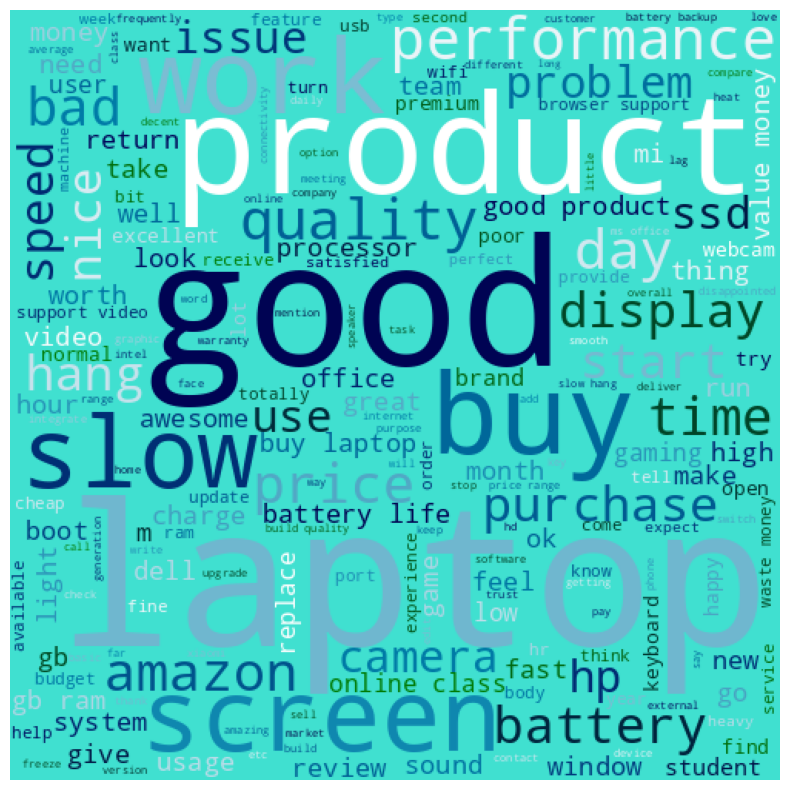

In [42]:
import wordcloud
from wordcloud import WordCloud

# combine all reviews
comment_data = ''
for comment in df['lemmatized_comments']:
  comment_data = comment_data +' '+ comment

# Plotting the word cloud
plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width = 500, height = 500, background_color='#40E0D0', colormap="ocean",  random_state=10).generate(comment_data)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Latent Dirichlet Allocation (LDA):

In [44]:
# Tokenize Review

tokenize_review = df['lemmatized_comments'].apply(lambda x: x.split())
id2word = corpora.Dictionary(tokenize_review)

# Create Corpora
texts = tokenize_review

# Term Documentary Frequency
corpus = [id2word.doc2bow(text) for text in texts]


#printing 10 words from the text corpus
corpus_example = [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]
corpus_example[0][:10]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('accord', 1),
 ('bad', 1),
 ('gb', 1),
 ('good', 1),
 ('hang', 1),
 ('laptop', 1),
 ('money', 1),
 ('plz', 1),
 ('ram', 1),
 ('slow', 2)]

In [45]:
# build LDA model for 10 topic
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           per_word_topics=True,
                                           eta = 0.6)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.006*"mi" + 0.004*"order" + 0.004*"wifi" + 0.004*"make" + 0.003*"connect" + 0.003*"connectivity" + 0.003*"surprise" + 0.003*"internet" + 0.003*"router" + 0.003*"receive"'), (1, '0.006*"turn" + 0.005*"help" + 0.005*"charger" + 0.003*"try" + 0.003*"work" + 0.003*"torne" + 0.002*"later" + 0.002*"will" + 0.002*"different" + 0.002*"find"'), (2, '0.043*"good" + 0.029*"laptop" + 0.019*"battery" + 0.015*"camera" + 0.014*"product" + 0.013*"screen" + 0.012*"like" + 0.011*"life" + 0.010*"quality" + 0.010*"light"'), (3, '0.019*"appario" + 0.019*"retailer" + 0.002*"super" + 0.001*"productin" + 0.001*"amazondelivere" + 0.001*"allthank" + 0.001*"emulator" + 0.001*"slownot" + 0.001*"android" + 0.001*"working"'), (4, '0.010*"amazon" + 0.009*"return" + 0.004*"customer" + 0.004*"order" + 0.004*"check" + 0.004*"switch" + 0.003*"usb" + 0.003*"tell" + 0.003*"option" + 0.003*"thank"'), (5, '0.003*"se" + 0.003*"raha" + 0.003*"hai" + 0.002*"june" + 0.002*"nahi" + 0.002*"kharab" + 0.002*"koi" + 0.002*"ma

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [47]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.124482 -0.082711       1        1  46.113360
7     -0.147943  0.072278       2        1  35.109998
4      0.038462  0.008814       3        1   6.164227
0      0.036492 -0.000252       4        1   4.653860
1      0.032163  0.000368       5        1   2.060608
9      0.032083 -0.000907       6        1   1.659929
8      0.032706  0.001234       7        1   1.280913
5      0.034398  0.000763       8        1   1.174955
6      0.029904 -0.000467       9        1   1.022308
3      0.036216  0.000879      10        1   0.759842, topic_info=               Term        Freq       Total Category  logprob  loglift
5            laptop  238.000000  238.000000  Default   30.000  30.0000
3              good  289.000000  289.000000  Default   29.000  29.0000
21          product  153.000000  153.000000  Default   28.000  28.0000
56          battery   61.000000   61.000000  Default   27.000  27.0000
323          amazon   21.000000   21.000000  Default   26.000  26.0000
...             ...         ...         ...      ...      ...      ...
1472          veery    0.031736    2.490221  Topic10   -7.383   0.5171
1446  childrenspeed    0.031736    2.490221  Topic10   -7.383   0.5171
455         awesome    0.031736   11.287169  Topic10   -7.383  -0.9942
878            owsm    0.031736    2.101173  Topic10   -7.383   0.6870
899          animal    0.031736    2.101173  Topic10   -7.383   0.6870

[463 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
509       1  0.194595       able
509       2  0.778380       able
1145      2  0.523291  accessory
853       1  0.575538   activity
873       1  0.578431   allthank
...     ...       ...        ...
332       1  0.557958    working
1473      2  0.401602      worse
1038      1  0.658824     xiaomi
1038      2  0.164706     xiaomi
1038      3  0.164706     xiaomi

[479 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 8, 5, 1, 2, 10, 9, 6, 7, 4])